<a href="https://colab.research.google.com/github/LobachArtemiy/DataCon-2025/blob/main/%D1%81%D0%B1%D0%BE%D1%80_%D0%B8_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сначала импортируем необходимые библиотеки

In [ ]:
# Установка зависимостей
!pip install "networkx==2.3" "decorator==4.3.0" "numpy<1.24" mordred[full] rdkit-pypi

In [ ]:
!pip install tqdm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import requests
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from tqdm import tqdm
from rdkit.Chem import AllChem

теперь мы загружаем из химической базы данных Chemble информацию о мишени GSK3B, которая является перспективной мишенью для лечения болезни Альцгеймера (данные загружены для Homo Sapiens)

In [ ]:
url = ("https://www.ebi.ac.uk/chembl/api/data/activity.json?"
       "target_chembl_id=CHEMBL262&standard_type=Ki&standard_units=nM&limit=10000") # CHEMBL262 - ID для мишени GSK3-B, выбираем константу ингибирования Ki, размерность концентрации лекарства в наномолях на литр (nM)

# Отправка GET-запроса к API ChEMBLE
resp = requests.get(url)

# Проверка успешности запроса
if resp.status_code == 200:
    data = resp.json()['activities']
    print(f"Количество записей, выведенных из базы данных ChEMBL: {len(data)}")

    # Преобразование в DataFrame
    df = pd.DataFrame(data)
df

Количество записей, выведенных из базы данных ChEMBL: 1000


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,281895,[],CHEMBL685261,Inhibition of protein kinase Glycogen synthase...,B,None,None,BAO_0000192,...,Homo sapiens,Glycogen synthase kinase-3 beta,9606,None,None,Ki,nM,UO_0000065,None,20.0
1,None,None,1438957,[],CHEMBL839940,Binding affinity for human glycogen synthase k...,B,None,None,BAO_0000192,...,Homo sapiens,Glycogen synthase kinase-3 beta,9606,None,None,Ki,uM,UO_0000065,None,0.02
2,None,None,1438961,[],CHEMBL839940,Binding affinity for human glycogen synthase k...,B,None,None,BAO_0000192,...,Homo sapiens,Glycogen synthase kinase-3 beta,9606,None,None,Ki,uM,UO_0000065,None,0.01
3,None,None,1438963,[],CHEMBL839940,Binding affinity for human glycogen synthase k...,B,None,None,BAO_0000192,...,Homo sapiens,Glycogen synthase kinase-3 beta,9606,None,None,Ki,uM,UO_0000065,None,0.01
4,None,None,1439062,[],CHEMBL839940,Binding affinity for human glycogen synthase k...,B,None,None,BAO_0000192,...,Homo sapiens,Glycogen synthase kinase-3 beta,9606,None,None,Ki,uM,UO_0000065,None,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,None,inactive,9653221,[],CHEMBL1963830,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,None,None,BAO_0000192,...,Homo sapiens,Glycogen synthase kinase-3 beta,9606,None,None,pKi,None,UO_0000065,None,5.4
996,None,active,9653222,[],CHEMBL1963830,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,None,None,BAO_0000192,...,Homo sapiens,Glycogen synthase kinase-3 beta,9606,None,None,pKi,None,UO_0000065,None,6.8
997,None,active,9653223,[],CHEMBL1963830,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,None,None,BAO_0000192,...,Homo sapiens,Glycogen synthase kinase-3 beta,9606,None,None,pKi,None,UO_0000065,None,7.2
998,None,active,9653224,[],CHEMBL1963830,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,None,None,BAO_0000192,...,Homo sapiens,Glycogen synthase kinase-3 beta,9606,None,None,pKi,None,UO_0000065,None,6.2


Теперь сделаем предобработку нашего датасета

In [ ]:
# Выбор нужных колонок и очистка данных
processed_df = df[['molecule_chembl_id', 'canonical_smiles', 'standard_value']].copy()

# Удаление пропущенных значений
processed_df = processed_df.dropna()

# Преобразование в числовой формат и фильтрация некорректных значений
processed_df['standard_value'] = pd.to_numeric(processed_df['standard_value'], errors='coerce')
processed_df = processed_df.dropna(subset=['standard_value'])
processed_df = processed_df[processed_df['standard_value'] > 0]

# Преобразование Ki в pKi (в наномолях)
processed_df['pValue'] = 9-np.log10(processed_df['standard_value'])

# Удаление дубликатов по SMILES
processed_df = processed_df.drop_duplicates(subset=['canonical_smiles'])
processed_df = processed_df.rename(columns={'canonical_smiles': 'smiles'})

print(f"После предобработки осталось {len(processed_df)} уникальных соединений")
# Восстановление правильной нумерации индексов
processed_df=processed_df.reset_index(drop=True)
processed_df

После предобработки осталось 971 уникальных соединений


,molecule_chembl_id,smiles,standard_value,pValue
0,CHEMBL298445,Cc1nc(N)sc1-c1ccnc(Nc2cccc([N+](=O)[O-])c2)n1,20.00,7.698970
1,CHEMBL182493,Cc1ccc2c(-c3ccnc(Nc4cccc(C(F)(F)F)c4)n3)c(-c3c...,20.00,7.698970
2,CHEMBL182326,Cc1ccc2c(-c3ccnc(Nc4ccc(F)c(F)c4)n3)c(-c3ccc(F...,10.00,8.000000
3,CHEMBL183064,Cc1ccc2c(-c3ccnc(Nc4ccc5c(c4)OCCO5)n3)c(-c3ccc...,10.00,8.000000
4,CHEMBL361038,Cc1ccc2c(-c3ccnc(Nc4ccc(Cl)c(C(F)(F)F)c4)n3)c(...,50.00,7.301030
...,...,...,...,...
966,CHEMBL49120,CCN(CC)CCOc1ccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O...,3981.07,5.400000
967,CHEMBL260135,Nc1n[nH]c2nnc(-c3ccccc3)c(-c3ccccc3)c12,158.49,6.799998
968,CHEMBL220241,CCn1c(-c2nonc2N)nc2cnc(Oc3cccc(NC(=O)c4ccc(OCC...,63.10,7.199971
969,CHEMBL2004544,O=S(=O)(O)c1ccc(NCc2ccc3c(c2)OCO3)c2c(O)cccc12,630.96,6.199998


теперь мы вычислим числовые молекулярные дескрипторы

In [ ]:
desc_names = [d[0] for d in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)
desc_data = []
for mol_repr in processed_df['smiles']:
    mol = None
    # Пробуем сначала как molblock, потом как SMILES
    try:
        mol = Chem.MolFromMolBlock(mol_repr, sanitize=True)
    except Exception:
        mol = None
    if mol is None:
        try:
            mol = Chem.MolFromSmiles(mol_repr)
        except Exception:
            mol = None
    # Если молекула невалидна, дескрипторы будут NaN
    if mol is not None:
        vals = calc.CalcDescriptors(mol)
        desc_data.append(vals)
    else:
        desc_data.append([np.nan]*len(desc_names))
df_desc = pd.DataFrame(desc_data, columns=desc_names)
df_rdkit = processed_df.reset_index(drop=True).join(df_desc)
print(f'После расчета дескрипторов: {len(df_rdkit)} строк')
print(f'Колонки после RDKit-дескрипторов ({len(df_rdkit.columns)}):')
print(list(df_rdkit.columns))

После расчета дескрипторов: 971 строк
Колонки после RDKit-дескрипторов (212):
['molecule_chembl_id', 'smiles', 'standard_value', 'pValue', 'MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_V

In [ ]:
#  Создаем датафрейм только с дескрипторами без информации об активности (pValue) и структуре молекулы (smiles)
df_descriptors_only = df_rdkit.drop(columns=['pValue', 'MOL'], errors='ignore')

print(f'Количество строк после удаления pValue и MOL: {df_descriptors_only.shape[0]}')
print(f'Количество столбцов после удаления pValue и MOL: {df_descriptors_only.shape[1]}')

# Удаляем нечисловые признаки для датафрейма, состоящего из одних дескрипторов
df_descriptors_only = df_descriptors_only.select_dtypes(include=[np.number])

print(f'Количество строк после удаления нечисловых признаков: {df_descriptors_only.shape[0]}')
print(f'Количество столбцов после удаления нечисловых признаков: {df_descriptors_only.shape[1]}')

# Удаляем признаки, где есть хотя бы один inf, -inf, NaN или экстремум в датафрейме из одних дескрипторов
extreme = 1e6
df_descriptors_only = df_descriptors_only.loc[:, (np.isfinite(df_descriptors_only).all(axis=0)) &
                                                (df_descriptors_only.abs() < extreme).all(axis=0)]

print(f'Количество строк после удаления признаков с inf, -inf, NaN или экстремумами: {df_descriptors_only.shape[0]}')
print(f'Количество столбцов после удаления признаков с inf, -inf, NaN или экстремумами: {df_descriptors_only.shape[1]}')


Количество строк после удаления pValue и MOL: 971
Количество столбцов после удаления pValue и MOL: 211
Количество строк после удаления нечисловых признаков: 971
Количество столбцов после удаления нечисловых признаков: 209
Количество строк после удаления признаков с inf, -inf, NaN или экстремумами: 971
Количество столбцов после удаления признаков с inf, -inf, NaN или экстремумами: 208


In [ ]:
# 7. Удаляем константные признаки, выводим результаты
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(df_descriptors_only)
selected_cols = df_descriptors_only.columns[selector.get_support()]
X_var = pd.DataFrame(X_var, columns=selected_cols, index=df_descriptors_only.index)

# 8. Удаляем высоко коррелированные признаки,  выводим результаты
corr = X_var.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_uncorr = X_var.drop(columns=to_drop)


теперь мы проведём нормировку молекулярных дескрипторов, чтобы они не "перетягивали" на себя внимание во время обучения наших моделей

Выбрано 56 компонент, объясняющих ≥95% дисперсии


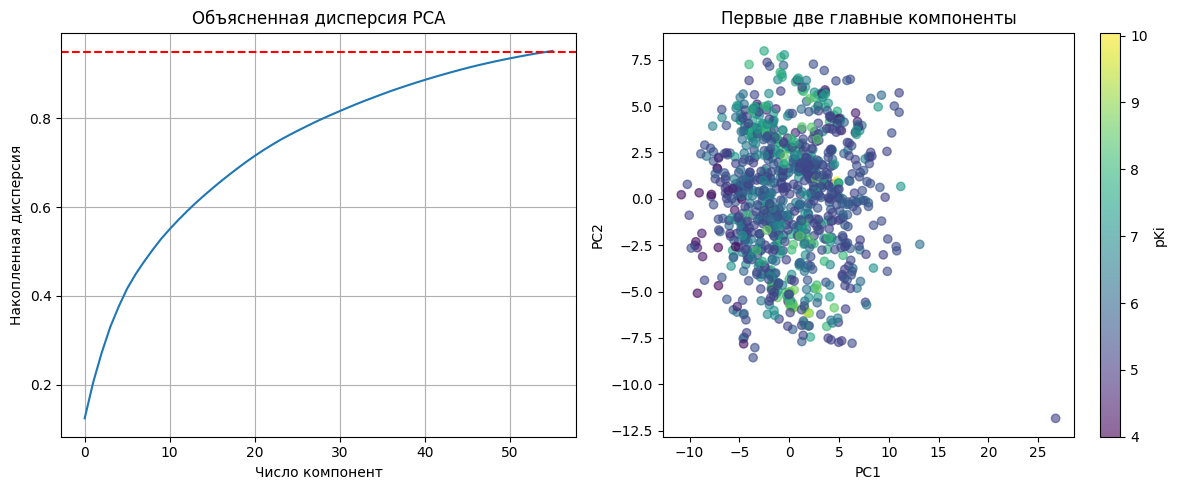

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_uncorr)
# Определение оптимального числа компонент (≥95% дисперсии)
pca = PCA().fit(X_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1

# Применение PCA
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(X_scaled)
print(f"Выбрано {n_components} компонент, объясняющих ≥95% дисперсии")

# Визуализация PCA
plt.figure(figsize=(12, 5))

# График объясненной дисперсии
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Число компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('Объясненная дисперсия PCA')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.grid()

# Scatter plot первых двух компонент
plt.subplot(1, 2, 2)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=processed_df['pValue'], cmap='viridis', alpha=0.6)
plt.colorbar(label='pKi')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Первые две главные компоненты')

plt.tight_layout()
plt.show()

и наконец, мы формируем окончательный датасет, который уже будет готов к обучению моделей

In [ ]:
# Создание DataFrame с PCA компонентами
pca_columns = [f'pca_{i+1}' for i in range(pca_features.shape[1])]
pca_df = pd.DataFrame(pca_features, columns=pca_columns)

# Объединение всех данных
final_df = pd.concat([
    processed_df[['molecule_chembl_id', 'smiles', 'pValue']],
    pca_df
], axis=1)

final_df

,molecule_chembl_id,smiles,pValue,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,...,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56
0,CHEMBL298445,Cc1nc(N)sc1-c1ccnc(Nc2cccc([N+](=O)[O-])c2)n1,7.698970,0.175340,-1.916410,-1.177015,1.303410,-1.940371,-3.457689,-4.056584,...,0.136759,-0.439231,-0.705320,-1.484948,-1.497831,-0.519799,-0.283873,-0.934489,0.562354,-0.249046
1,CHEMBL182493,Cc1ccc2c(-c3ccnc(Nc4cccc(C(F)(F)F)c4)n3)c(-c3c...,7.698970,4.830320,4.720097,-6.048858,4.901976,0.494477,1.556537,-0.529229,...,-0.277979,-0.723885,-0.207798,-0.466748,-0.532699,0.229258,-0.164938,-0.125851,0.165480,0.216871
2,CHEMBL182326,Cc1ccc2c(-c3ccnc(Nc4ccc(F)c(F)c4)n3)c(-c3ccc(F...,8.000000,2.954056,5.070312,-3.667544,3.299032,0.748056,-0.241208,-1.233225,...,-0.107019,0.898658,-1.051557,0.325509,-0.103288,-0.448536,0.023578,-0.417369,0.287566,-0.444571
3,CHEMBL183064,Cc1ccc2c(-c3ccnc(Nc4ccc5c(c4)OCCO5)n3)c(-c3ccc...,8.000000,4.454018,4.352885,0.604514,2.185117,3.246041,-1.878639,1.030125,...,-0.683889,-0.448741,-0.813763,-0.938472,-0.012356,0.175566,0.988425,0.001853,0.525168,-0.134933
4,CHEMBL361038,Cc1ccc2c(-c3ccnc(Nc4ccc(Cl)c(C(F)(F)F)c4)n3)c(...,7.301030,5.168279,4.331109,-6.495174,4.907972,-0.932461,1.105451,2.319425,...,-0.180576,-1.016014,-0.296998,-0.014852,-0.553451,0.168620,-0.039798,-0.195770,0.168756,0.161863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,CHEMBL49120,CCN(CC)CCOc1ccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O...,5.400000,3.906259,1.324165,1.635685,-0.811574,-0.397663,-0.147009,6.088201,...,-0.596437,0.355416,-0.745875,-0.093164,-0.743873,0.548846,1.804762,-0.439813,0.409258,0.982301
967,CHEMBL260135,Nc1n[nH]c2nnc(-c3ccccc3)c(-c3ccccc3)c12,6.799998,-3.599790,4.856645,-1.080567,-3.107583,1.374552,-1.711364,-1.581758,...,1.867421,0.982600,0.797014,-0.510352,-0.245905,0.297536,0.482027,-0.488734,0.990201,-0.223829
968,CHEMBL220241,CCn1c(-c2nonc2N)nc2cnc(Oc3cccc(NC(=O)c4ccc(OCC...,7.199971,11.203594,0.668157,6.667557,2.274924,3.063946,-3.354720,1.636528,...,-1.431640,0.558261,0.030640,-1.177558,2.032931,1.039980,1.510013,-0.156827,0.467555,0.461586
969,CHEMBL2004544,O=S(=O)(O)c1ccc(NCc2ccc3c(c2)OCO3)c2c(O)cccc12,6.199998,1.643860,-3.713462,-3.478024,0.241048,2.297707,0.812921,1.284555,...,-1.543091,1.182225,0.020614,-0.279645,0.367256,0.440054,-0.246775,2.540877,-0.021512,0.714408


теперь мы сгенерим фингерпринты с 2048-битными отпечатками Моргана с радиусом 2 для SMILES-строк и добавим их в финальный датасет

In [ ]:
def generate_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    """
    Генерация Morgan Fingerprint для SMILES-строки

    Параметры:
        smiles (str): SMILES-строка
        radius (int): Радиус окружения (по умолчанию 2)
        n_bits (int): Размер отпечатка (по умолчанию 2048)

    Возвращает:
        list: Битовая последовательность отпечатка
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
    return np.array(fp)

In [ ]:
from typing_extensions import final
# Генерация отпечатков и добавление в датасет
final_df['Morgan_Fingerprint'] = final_df['smiles'].apply(lambda x: generate_morgan_fingerprint(x, radius=2, n_bits=2048))

final_df.to_csv('train_datacet.csv')
final_df

,molecule_chembl_id,smiles,pValue,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,...,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,Morgan_Fingerprint
0,CHEMBL298445,Cc1nc(N)sc1-c1ccnc(Nc2cccc([N+](=O)[O-])c2)n1,7.698970,0.175340,-1.916410,-1.177015,1.303410,-1.940371,-3.457689,-4.056584,...,-0.439231,-0.705320,-1.484948,-1.497831,-0.519799,-0.283873,-0.934489,0.562354,-0.249046,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL182493,Cc1ccc2c(-c3ccnc(Nc4cccc(C(F)(F)F)c4)n3)c(-c3c...,7.698970,4.830320,4.720097,-6.048858,4.901976,0.494477,1.556537,-0.529229,...,-0.723885,-0.207798,-0.466748,-0.532699,0.229258,-0.164938,-0.125851,0.165480,0.216871,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL182326,Cc1ccc2c(-c3ccnc(Nc4ccc(F)c(F)c4)n3)c(-c3ccc(F...,8.000000,2.954056,5.070312,-3.667544,3.299032,0.748056,-0.241208,-1.233225,...,0.898658,-1.051557,0.325509,-0.103288,-0.448536,0.023578,-0.417369,0.287566,-0.444571,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL183064,Cc1ccc2c(-c3ccnc(Nc4ccc5c(c4)OCCO5)n3)c(-c3ccc...,8.000000,4.454018,4.352885,0.604514,2.185117,3.246041,-1.878639,1.030125,...,-0.448741,-0.813763,-0.938472,-0.012356,0.175566,0.988425,0.001853,0.525168,-0.134933,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL361038,Cc1ccc2c(-c3ccnc(Nc4ccc(Cl)c(C(F)(F)F)c4)n3)c(...,7.301030,5.168279,4.331109,-6.495174,4.907972,-0.932461,1.105451,2.319425,...,-1.016014,-0.296998,-0.014852,-0.553451,0.168620,-0.039798,-0.195770,0.168756,0.161863,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,CHEMBL49120,CCN(CC)CCOc1ccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O...,5.400000,3.906259,1.324165,1.635685,-0.811574,-0.397663,-0.147009,6.088201,...,0.355416,-0.745875,-0.093164,-0.743873,0.548846,1.804762,-0.439813,0.409258,0.982301,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
967,CHEMBL260135,Nc1n[nH]c2nnc(-c3ccccc3)c(-c3ccccc3)c12,6.799998,-3.599790,4.856645,-1.080567,-3.107583,1.374552,-1.711364,-1.581758,...,0.982600,0.797014,-0.510352,-0.245905,0.297536,0.482027,-0.488734,0.990201,-0.223829,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
968,CHEMBL220241,CCn1c(-c2nonc2N)nc2cnc(Oc3cccc(NC(=O)c4ccc(OCC...,7.199971,11.203594,0.668157,6.667557,2.274924,3.063946,-3.354720,1.636528,...,0.558261,0.030640,-1.177558,2.032931,1.039980,1.510013,-0.156827,0.467555,0.461586,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
969,CHEMBL2004544,O=S(=O)(O)c1ccc(NCc2ccc3c(c2)OCO3)c2c(O)cccc12,6.199998,1.643860,-3.713462,-3.478024,0.241048,2.297707,0.812921,1.284555,...,1.182225,0.020614,-0.279645,0.367256,0.440054,-0.246775,2.540877,-0.021512,0.714408,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


сохраним наши лиганды и мишень в формат .sdf для теста моделей

In [ ]:
from rdkit.Chem import SDWriter

smiles_list = processed_df['smiles'].tolist()

# Создание файла SDF
with Chem.SDWriter('output.sdf') as writer:
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Генерация 3D-координат
            AllChem.EmbedMolecule(mol)
            # Опционально: минимизация энергии молекулы
            AllChem.UFFOptimizeMolecule(mol)
            writer.write(mol)


[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling AddHs()
[07:50:01] Molecule does not have explicit Hs. Consider calling 

In [ ]:
def download_sdf(pdb_id):
    # Скачивание мишени в формате sdf
    url = f'https://www.rcsb.org/pdb/download/downloadFile.do?fileFormat=sdf&compression=NO&structureId=pdb_00002o5k'


# Make a GET request to the API
response = requests.get(url)

# Check the status code of the response
if response.status_code == 200:
    # Save the SDF file to the current directory
    with open(f'target.sdf', 'wb') as f:
        f.write(response.content)
    print(f'SDF file for pdb_00002o5k saved successfully.')
else:
    print(f'Error downloading SDF file for {pdb_id}.')
download_sdf('1c5n')

SDF file for pdb_00002o5k saved successfully.


теперь мы посмотрим на распределение активности лигандов (в идеале, чтобы оно было нормальным)

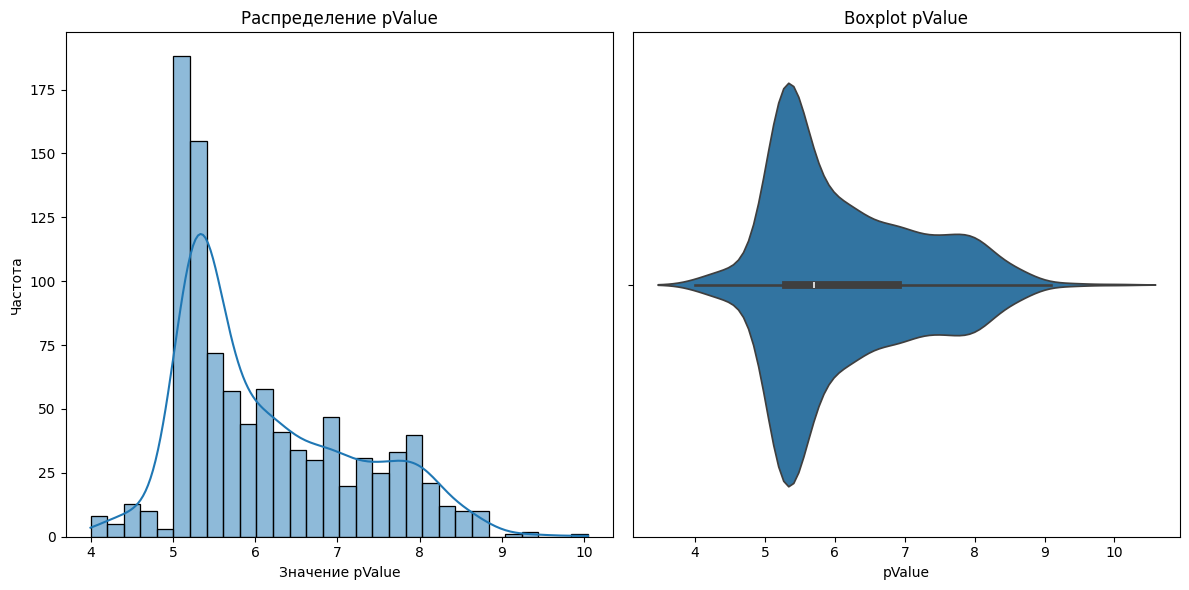

In [ ]:
# Анализ распределения целевой переменной pValue
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(processed_df['pValue'], bins=30, kde=True)
plt.title('Распределение pValue')
plt.xlabel('Значение pValue')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.violinplot(processed_df,x=processed_df['pValue'])
plt.title('Boxplot pValue')
plt.tight_layout()
plt.show()

мы видим, что наше распределение не совсем похоже на нормальное, местами есть некоторые провалы. Мы видим также смещение пика влево, пиковое значение pValue находится в районе 5,5. По violinplot мы видим, что выбросов в данных не наблюдается, поэтому мы все данные оставляем.